In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3072)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
# 1.基本文本卷积
# For more information, refer to:
# Kim 2014 (http://emnlp2014.org/papers/pdf/EMNLP2014181.pdf)
# Zhang et al 2015 (https://papers.nips.cc/paper/5782-character-level-convolutional-networks-for-text-classification.pdf)
# --------------------- 


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [4]:
num_features = 3000
sequence_length = 300
embedding_dimension = 100


In [5]:
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=num_features)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)



(25000,)
(25000,)
(25000,)
(25000,)


In [6]:
x_train = pad_sequences(x_train, maxlen=sequence_length)
x_test = pad_sequences(x_test, maxlen=sequence_length)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


(25000, 300)
(25000, 300)
(25000,)
(25000,)


In [7]:
# 2.构造基本句子分类器

In [8]:
def imdb_cnn():
    model = keras.Sequential([
        layers.Embedding(input_dim=num_features, output_dim=embedding_dimension,input_length=sequence_length),
        layers.Conv1D(filters=50, kernel_size=5, strides=1, padding='valid'),
        layers.MaxPool1D(2, padding='valid'),
        layers.Flatten(),
        layers.Dense(10, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                 loss=keras.losses.BinaryCrossentropy(),
                 metrics=['accuracy'])
    
    return model


In [9]:
model = imdb_cnn()
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 100)          300000    
_________________________________________________________________
conv1d (Conv1D)              (None, 296, 50)           25050     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 148, 50)           0         
_________________________________________________________________
flatten (Flatten)            (None, 7400)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                74010     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 399,071
Trainable params: 399,071
Non-trainable params: 0
__________________________________________________

In [10]:
%%time
history = model.fit(x_train, y_train, batch_size=64, epochs=5, validation_split=0.1)


W0711 07:56:14.104121 140630370252544 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 22500 samples, validate on 2500 samples
Epoch 1/5
22500/22500 [==============================] - 8s 372us/sample - loss: 0.6932 - accuracy: 0.5007 - val_loss: 0.6932 - val_accuracy: 0.4876
Epoch 2/5
22500/22500 [==============================] - 6s 280us/sample - loss: 0.3826 - accuracy: 0.8175 - val_loss: 0.3031 - val_accuracy: 0.8744
Epoch 3/5
22500/22500 [==============================] - 6s 279us/sample - loss: 0.2053 - accuracy: 0.9193 - val_loss: 0.3054 - val_accuracy: 0.8744
Epoch 4/5
22500/22500 [==============================] - 6s 283us/sample - loss: 0.0772 - accuracy: 0.9772 - val_loss: 0.4001 - val_accuracy: 0.8684
Epoch 5/5
22500/22500 [==============================] - 6s 281us/sample - loss: 0.0125 - accuracy: 0.9984 - val_loss: 0.5082 - val_accuracy: 0.8704
CPU times: user 48.7 s, sys: 3.68 s, total: 52.4 s
Wall time: 34.9 s


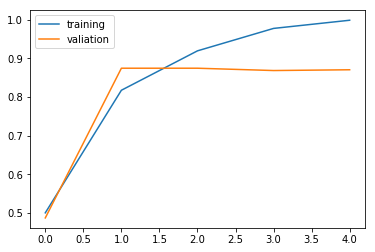

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'valiation'], loc='upper left')
plt.show()


In [12]:
# 3.多核卷积网络

In [13]:
filter_sizes=[3,4,5]
def convolution():
    inn = layers.Input(shape=(sequence_length, embedding_dimension, 1))
    cnns = []
    for size in filter_sizes:
        conv = layers.Conv2D(filters=64, kernel_size=(size, embedding_dimension),
                            strides=1, padding='valid', activation='relu')(inn)
        pool = layers.MaxPool2D(pool_size=(sequence_length-size+1, 1), padding='valid')(conv)
        cnns.append(pool)
    outt = layers.concatenate(cnns)
    
    model = keras.Model(inputs=inn, outputs=outt)
    return model

def cnn_mulfilter():
    model = keras.Sequential([
        layers.Embedding(input_dim=num_features, output_dim=embedding_dimension,
                        input_length=sequence_length),
        layers.Reshape((sequence_length, embedding_dimension, 1)),
        convolution(),
        layers.Flatten(),
        layers.Dense(10, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
        
    ])
    model.compile(optimizer=keras.optimizers.Adam(),
                 loss=keras.losses.BinaryCrossentropy(),
                 metrics=['accuracy'])
    return model

model = cnn_mulfilter()
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 100)          300000    
_________________________________________________________________
reshape (Reshape)            (None, 300, 100, 1)       0         
_________________________________________________________________
model (Model)                (None, 1, 1, 192)         76992     
_________________________________________________________________
flatten_1 (Flatten)          (None, 192)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1930      
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [14]:
%%time
history = model.fit(x_train, y_train, batch_size=64, epochs=5, validation_split=0.1)


Train on 22500 samples, validate on 2500 samples
Epoch 1/5
22500/22500 [==============================] - 17s 770us/sample - loss: 0.5408 - accuracy: 0.7066 - val_loss: 0.3383 - val_accuracy: 0.8556
Epoch 2/5
22500/22500 [==============================] - 16s 722us/sample - loss: 0.2917 - accuracy: 0.8841 - val_loss: 0.2821 - val_accuracy: 0.8880
Epoch 3/5
22500/22500 [==============================] - 16s 722us/sample - loss: 0.2083 - accuracy: 0.9254 - val_loss: 0.2912 - val_accuracy: 0.8880
Epoch 4/5
22500/22500 [==============================] - 16s 721us/sample - loss: 0.1475 - accuracy: 0.9508 - val_loss: 0.3096 - val_accuracy: 0.8836
Epoch 5/5
22500/22500 [==============================] - 16s 723us/sample - loss: 0.0945 - accuracy: 0.9719 - val_loss: 0.3520 - val_accuracy: 0.8844
CPU times: user 1min 11s, sys: 8.3 s, total: 1min 20s
Wall time: 1min 23s


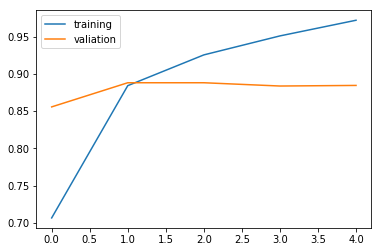

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'valiation'], loc='upper left')
plt.show()
